<div align="right"><i>Peter Norvig<br>March 2019<br>Updated May 2021</i></div>

# Pairing Socks

[**Bram Cohen**](https://en.wikipedia.org/wiki/Bram_Cohen) posed a problem:

> *You have N pairs of socks, all different, in the dryer. 
You pull random socks out one-by-one, placing each sock in one of C possible spaces on the countertop. 
After putting a sock down on the countertop you compare it to the other socks on the countertop, and if there is a match, you put the pair away in a drawer, freeing up two spaces.  We can ask:*
1. *Given N pairs of socks and C spaces, what's the probability P(N, C) that you will pair up all the socks before you run out of spaces?*
2. *Given N pairs of socks, what is the minimum C such that P(N, C) > 1/2?*

Here's how I think about computing *P(N, C)*:

- Can I come up with a closed form mathematical formula? **No,** I'm not smart enough.
- Could I do a Monte Carlo simulation? **Yes**, but the resulting probability numbers would not be precise.
- Could I do a simple brute-force computation? **Yes**, but only for very small values of *N*.
- Could I define an efficient algorithm? **Yes,** that's what this notebook is about.


First get some imports out of the way:


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from functools import lru_cache
from itertools import permutations

# Brute-Force Approach

A straightforward brute-force way to compute *P(N, C)* would be to consider every possible ordering in which we could pull the  socks from the dryer, and count how many of these orderings are pairable. For example, with *N* = 2 pairs of socks, there are 24 possible orderings:

In [2]:
socks = ('▢', '▢', '▩', '▩')
list(permutations(socks))

[('▢', '▢', '▩', '▩'),
 ('▢', '▢', '▩', '▩'),
 ('▢', '▩', '▢', '▩'),
 ('▢', '▩', '▩', '▢'),
 ('▢', '▩', '▢', '▩'),
 ('▢', '▩', '▩', '▢'),
 ('▢', '▢', '▩', '▩'),
 ('▢', '▢', '▩', '▩'),
 ('▢', '▩', '▢', '▩'),
 ('▢', '▩', '▩', '▢'),
 ('▢', '▩', '▢', '▩'),
 ('▢', '▩', '▩', '▢'),
 ('▩', '▢', '▢', '▩'),
 ('▩', '▢', '▩', '▢'),
 ('▩', '▢', '▢', '▩'),
 ('▩', '▢', '▩', '▢'),
 ('▩', '▩', '▢', '▢'),
 ('▩', '▩', '▢', '▢'),
 ('▩', '▢', '▢', '▩'),
 ('▩', '▢', '▩', '▢'),
 ('▩', '▢', '▢', '▩'),
 ('▩', '▢', '▩', '▢'),
 ('▩', '▩', '▢', '▢'),
 ('▩', '▩', '▢', '▢')]

Of these 24 orderings, there are just 6 *distinct* ones:

In [3]:
set(permutations(socks))

{('▢', '▢', '▩', '▩'),
 ('▢', '▩', '▢', '▩'),
 ('▢', '▩', '▩', '▢'),
 ('▩', '▢', '▢', '▩'),
 ('▩', '▢', '▩', '▢'),
 ('▩', '▩', '▢', '▢')}

When there are *C* = 2 spaces,  the first and last of these 6 orderings can be paired up, but the others cannot, so *P*(2, 2) = 2/6 = 1/3.

In general there are (2*N*)! orderings, and (2*N*)! / 2<sup><i>N</i></sup> distinct orderings.   This is faster-than-exponential growth. With 10 pairs of socks (and I personally have at least that many, although they might not all be in the dryer at once) there are **2 quintillion** permutations, and **2 quadrillion** distinct permutations.

# Answering Question 1: P(N, C)

Fortunately, I don't need to look at every possible ordering to answer the questions. If the first three socks I pull are, say,  white, black, and red (WBR), then for the purposes of this problem that's exactly the same as pulling RBW or BRW or RBG. The identity of each sock doesn't matter; all that matters is how many socks are on the countertop (here, 3 in each case), and how many pairs remain to be matched. 

Suppose that we have *C*  spaces on the countertop (this number never changes), that *k* of these spaces currently hold socks  (this number can rise and fall as we go), and that *N* pairs of socks remain to be paired (this number will hopefully be reduced over time). There are four possibile cases:
- We've succeeded (*P(N, C)* = 1) if there are no more socks to pair (*N* = 0) or if there are fewer pairs remaining than the number of spaces (*N* < *C*). When there are more spaces than pairs, the worst that can happen is that there is one of each pair on the counter, with one space left; from there we can always pair all the socks.
- We've failed (*P(N, C)* = 0) if the countertop is full (*k* ≥ *C*); there's nowhere for the next sock from the dryer to go. 
- If *k* = 0, then the next sock from the dryer becomes the lone sock on the counter.
- Otherwise we might succceed or fail, depending on the ordering of the remaining socks in the dryer, of which there are   *r* = 2*N* - *k*.  Two things can happen with the next sock pulled from the dryer; consider both cases and add their weighted probabilities:
  - *k* out of *r* remaining socks match a countertop sock, leaving *k* - 1 socks on the counter, and *N* - 1 pairs to match.
  - (*r* - *k*) out of *r* remaining socks don't match, giving us *k* + 1 socks on the counter.


With that, I can code up a solution and try it:

In [4]:
@lru_cache(None)
def P(N, C, k=0) -> float:
    """The probability that we can pair up N pairs of socks using C counter spaces,
    assuming there are currently k socks on the counter."""
    if N == 0 or N < C:
        return 1
    elif k >= C:
        return 0
    elif k == 0:
        return P(N, C, 1)
    else:
        r = 2 * N - k # Number of remaining socks in the dryer
        match   =      k  * P(N - 1, C, k - 1)
        nomatch = (r - k) * P(N,     C, k + 1)
        return (match + nomatch) / r

In [5]:
P(2, 2) # The probability of pairing up 2 pairs of socks using 2 spaces

0.3333333333333333

In [6]:
P(10, 7) # The probability of pairing up 10 pairs of socks using 7 spaces

0.5105559043639538

In [7]:
%time P(400, 200) # The probability of pairing up 400 pairs of socks using 200 spaces

CPU times: user 24 ms, sys: 1.69 ms, total: 25.7 ms
Wall time: 25.4 ms


0.22085941648149854

Clearly `P` is fast, and these answers look reasonable. But are they actually correct? Here are some tests with the right answers computed by hand:

In [8]:
for N in range(1, 10):
    assert P(N, N + 1) == 1 # N + 1 spaces always works
    assert P(N, 1)     == 0 # 1 space always fails
assert P(0, 0) == 1         # Zero socks can always be paired
assert P(2, 2) == 1/3       # Only works if 2nd sock matches 1st; there's a 1/3 chance of that
assert P(3, 2) == 1/15      # 1/5 for 2nd sock to match 1st; reduces to f(2, 2) 
assert P(4, 2) == P(4, 2, 1) == (1 * P(3, 2, 0) + 6 * P(4, 2, 2)) / 7 # r = 7 remaining socks, only 1 matches

Why is `P` so fast (especially given that the brute-force approach was so slow)? You can think of each call to `P(N, C)` as mostly fetching probabilities from the cache, then perhaps doing a small bit of arithmetic and adding a new entry in the cache.  So most of the run time is going to be in cache management. A call to `P(N, C, 0)` will fill cache entries for the first argument ranging from 0 to `N`, and the third ranging from 0 to `C`,  so the cache can have no more than *N* × *C* entries, and the run time (and space) requirements should be at worst linear in *N* and *C* (or you could call it quadratic in *N*).


# Visualizing P(N, C)

I can plot *P(N, C)* for various values of the number of pairs of socks, *N*, each denoted by a different color S-shaped curve, and of the number of countertop spaces, *C*, each denoted by a point on a curve:

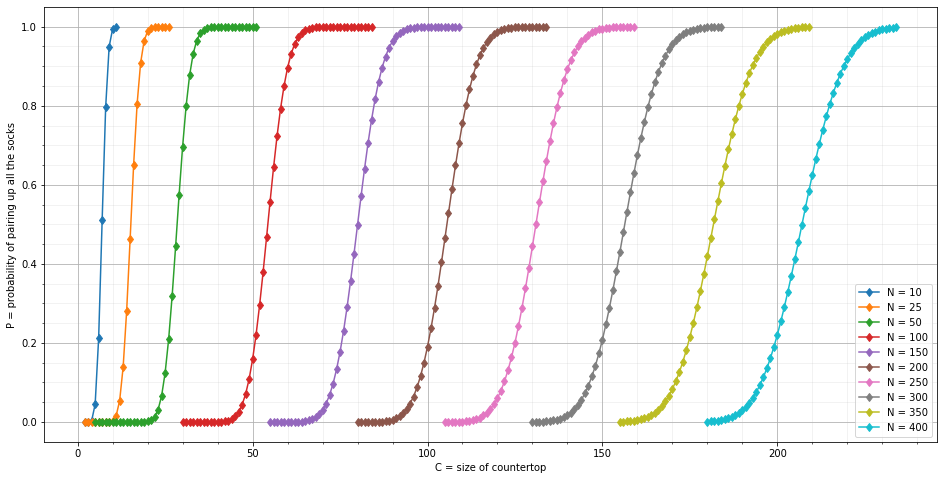

In [9]:
def fig(xlabel, ylabel):
    """Set up a figure."""
    plt.figure(figsize=(16,8)); plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.minorticks_on()
    plt.grid(b=True, which='major')
    plt.grid(b=True, which='minor', alpha=0.2)
    
def plotPs(Ns):
    """Plot P(N, C) versus C for various values of N and C."""
    fig('C = size of countertop', 'P = probability of pairing up all the socks')
    for N in Ns:
        Cs = range(max(2, N // 2 - 20), min(N + 2, N // 2 + 35))
        Ps = [P(N, C) for C in Cs]
        plt.plot(Cs, Ps, 'd-', label='N = {}'.format(N))
    plt.legend()
        
Ns = [10, 25, *range(50, 401, 50)]
plotPs(Ns)

For example, the rightmost cyan curve corresponds to *N* = 400, with *C* values ranging from 180 to 235. The cyan point on the *C* = 200 vertical line says that *P*(400, 200) is a little more than 0.2.

Alternatively, we can have the X-axis show not the countertop size *C*, but rather the ratio *C*/*N*:

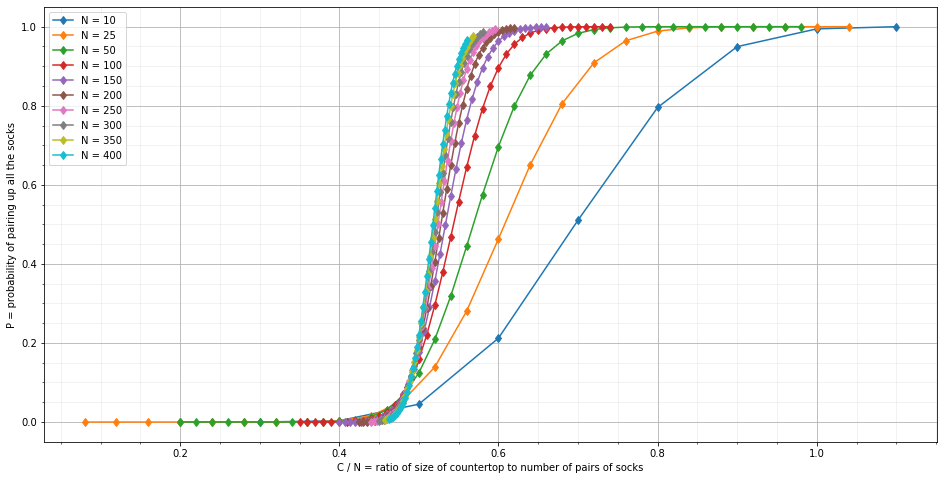

In [10]:
def plotPs2(Ns):
    """Plot P(N, C) versus C/N for various values of N and C."""
    fig('C / N = ratio of size of countertop to number of pairs of socks', 
        'P = probability of pairing up all the socks')
    for N in Ns:
        Cs = range(max(2, N // 2 - 15), min(N + 2, N // 2 + 25))
        Xs = [C / N for C in Cs]
        Ps = [P(N, C) for C in Cs]
        plt.plot(Xs, Ps, 'd-', label='N = {}'.format(N))
    plt.legend()
    
plotPs2(Ns)

This shows that as *N* increases, there is a convergence to similar shaped and positioned curves where there is a rapid change from *P(N, C)* ≊ 0 to *P(N, C)* ≊ 1 in the range 0.4 < *C* / *N* < 0.6. (For lower values of *N*, the shape of the curve is not as steep.)

# Answering Question 2: minimum_C(N)

For question 2, I can try values of *C* until I find one where *P(N, C)* ≥ 50%. If I was worried about efficiency I could do a binary search, but I'm more worried about clarity and correctness, so I'll do a linear search, with a little trick to set a good starting value.

In [11]:
def minimum_C(N, p=0.5) -> int: 
    """Minimum countertop size C needed to have P(N, C) ≥ p."""
    start_C = N // 2 if P(N, N // 2) < p else 0
    return next(C for C in range(start_C, N + 2) if P(N, C) >= p)

In [12]:
minimum_C(10) # How many spaces do I need to have at least a 50% chance of pairing up 10 pairs of socks?

7

In [13]:
minimum_C(400) # 400 pairs of socks?

208

# Visualizing minimum_C(N)

What's the minimum *C* that causes `P(N, C)` to be at least 50% (or in general any probability value)? We can visualize this as a plot:

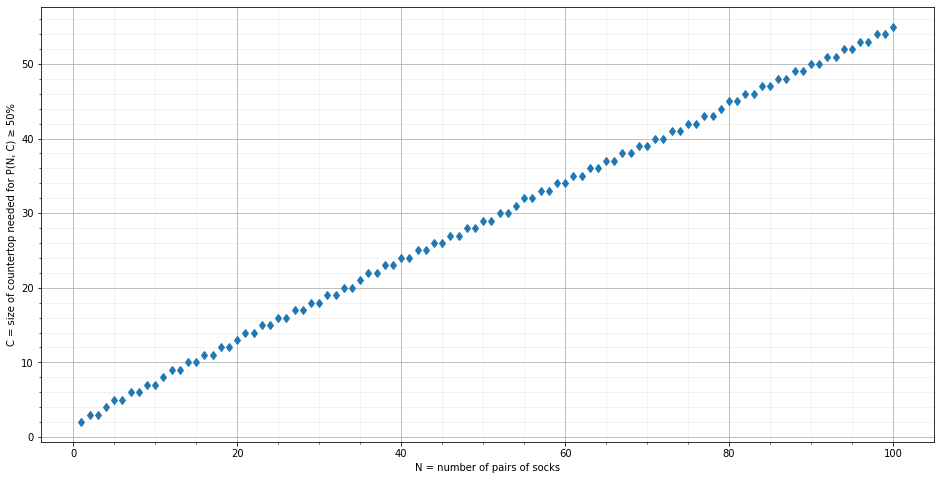

In [14]:
def plotCs(Ns, p=0.5):
    """Plot minimum_C(N) for various values of N."""
    fig('N = number of pairs of socks', 
        f'C = size of countertop needed for P(N, C) ≥ {p:.0%}')
    Cs = [minimum_C(N, p) for N in Ns]
    plt.plot(Ns, Cs, 'd')
    
plotCs(range(1, 101))

The points are almost on a straight line. (I don't fully understand the variation.)

As we discovered in the previous plot, *C* needs to be a little over half of *N* to get *P(N, C)* > 50%.

One weakness of my implementation of `P(N, C)` is that it can quickly exceed Python's built-in recursion limit. To get around that, we could (a) only use values of `N` and `C` that keep us below the default recursion limit of 1000; or (b) reimplement `P` to not be recursive; or (c) increase the recursion limit:

In [15]:
import sys
sys.setrecursionlimit(50_000)

%time P(10_000, 5_022)

CPU times: user 25.3 s, sys: 1.15 s, total: 26.5 s
Wall time: 26.5 s


0.5070227508048063

Here is a table of `minimum_C` values reaching up to *N* = 2000:

In [16]:
%%time
for N in [10, 50, 100, *range(200, 2001, 200)]:
    C = minimum_C(N)
    print(f'N = {N:4};  C = {C:4};  C/N = {C / N:.3f};  C-N/2 = {C - N // 2:2}')

N =   10;  C =    7;  C/N = 0.700;  C-N/2 =  2
N =   50;  C =   29;  C/N = 0.580;  C-N/2 =  4
N =  100;  C =   55;  C/N = 0.550;  C-N/2 =  5
N =  200;  C =  106;  C/N = 0.530;  C-N/2 =  6
N =  400;  C =  208;  C/N = 0.520;  C-N/2 =  8
N =  600;  C =  309;  C/N = 0.515;  C-N/2 =  9
N =  800;  C =  409;  C/N = 0.511;  C-N/2 =  9
N = 1000;  C =  510;  C/N = 0.510;  C-N/2 = 10
N = 1200;  C =  611;  C/N = 0.509;  C-N/2 = 11
N = 1400;  C =  711;  C/N = 0.508;  C-N/2 = 11
N = 1600;  C =  812;  C/N = 0.507;  C-N/2 = 12
N = 1800;  C =  912;  C/N = 0.507;  C-N/2 = 12
N = 2000;  C = 1013;  C/N = 0.506;  C-N/2 = 13
CPU times: user 43.3 s, sys: 1.97 s, total: 45.3 s
Wall time: 45.3 s


I'm going to stop here, but there are several things you could work on if you're interested:
- Can you develop a closed form mathematical formula for *P(N, C)*?. 
- Can you run a Monte Carlo simulation? 
- Can you display an animation of the sock-pairing process?
- Can you implement a brute-force enumeration, and use it to verify *P(N, C)* on small values?
- Can you reimplement `P` to not be recursive?
- Can you compute a full probability distribution over the number of pairs of socks paired up?
- What else would you like to explore?